In [ ]:
import zipfile
with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

import os
import xml.etree.ElementTree as ET
from PIL import Image
from pathlib import Path

# Paths to your dataset
annotations_path = Path(r'/content/archive/annotations')
images_path = Path(r'/content/archive/images')

# List all XML files in the directory
xml_files = list(annotations_path.glob('*.xml'))

# List all PNG images in the directory
png_images = list(images_path.glob('*.png'))

# Desired size of the input images
IMG_WIDTH = 224
IMG_HEIGHT = 224

# Function to parse XML file
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    boxes = []
    for member in root.findall('object'):
        bndbox = member.find('bndbox')  # Directly find the 'bndbox' tag
        boxes.append({
            'label': member.find('name').text,
            'xmin': int(bndbox.find('xmin').text),
            'ymin': int(bndbox.find('ymin').text),
            'xmax': int(bndbox.find('xmax').text),
            'ymax': int(bndbox.find('ymax').text),
        })
    return boxes

# Function to resize image and adjust annotations accordingly
def resize_image(image_path, boxes, img_width, img_height):
    with Image.open(image_path) as img:
        # Get original dimensions
        original_width, original_height = img.size

        # Calculate resize ratios
        width_ratio = img_width / original_width
        height_ratio = img_height / original_height

        # Resize image
        img_resized = img.resize((img_width, img_height))

        # Adjust boxes coordinates
        for box in boxes:
            box['xmin'] = int(box['xmin'] * width_ratio)
            box['ymin'] = int(box['ymin'] * height_ratio)
            box['xmax'] = int(box['xmax'] * width_ratio)
            box['ymax'] = int(box['ymax'] * height_ratio)

    return img_resized, boxes

# Process dataset
dataset = []
for xml_file in xml_files:
    # Parse the XML file for annotations
    boxes = parse_annotation(xml_file)

    # Find the corresponding image file
    image_file = images_path / xml_file.with_suffix('.png').name

    # Resize image and adjust annotations
    resized_image, adjusted_boxes = resize_image(image_file, boxes, IMG_WIDTH, IMG_HEIGHT)

    # Save the resized image to a new file
    resized_image_path = images_path / f"resized_{image_file.name}"
    resized_image.save(resized_image_path)

    # Add to the dataset list
    dataset.append({
        'image_path': resized_image_path,
        'annotations': adjusted_boxes
    })

# Let's return the paths to the resized images and a sample of the annotations for verification
sample_dataset = [(entry['image_path'].name, entry['annotations']) for entry in dataset[:5]]
sample_dataset

[('resized_maksssksksss248.png',
  [{'label': 'without_mask',
    'xmin': 93,
    'ymin': 104,
    'xmax': 137,
    'ymax': 165}]),
 ('resized_maksssksksss54.png',
  [{'label': 'with_mask', 'xmin': 66, 'ymin': 33, 'xmax': 87, 'ymax': 67},
   {'label': 'with_mask', 'xmin': 110, 'ymin': 57, 'xmax': 127, 'ymax': 92},
   {'label': 'with_mask', 'xmin': 176, 'ymin': 67, 'xmax': 189, 'ymax': 94},
   {'label': 'without_mask', 'xmin': 90, 'ymin': 65, 'xmax': 99, 'ymax': 82}]),
 ('resized_maksssksksss322.png',
  [{'label': 'with_mask', 'xmin': 44, 'ymin': 56, 'xmax': 138, 'ymax': 141}]),
 ('resized_maksssksksss288.png',
  [{'label': 'with_mask', 'xmin': 15, 'ymin': 200, 'xmax': 29, 'ymax': 215},
   {'label': 'with_mask', 'xmin': 80, 'ymin': 92, 'xmax': 98, 'ymax': 125},
   {'label': 'with_mask', 'xmin': 110, 'ymin': 96, 'xmax': 128, 'ymax': 124}]),
 ('resized_maksssksksss745.png',
  [{'label': 'with_mask',
    'xmin': 108,
    'ymin': 127,
    'xmax': 165,
    'ymax': 183}])]

# **Unsupervised Learning**

In [ ]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define paths to your datasets
annotations_path = Path('/content/archive/annotations')
images_path = Path('/content/archive/images')

# Function to parse XML file for annotations
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    boxes = []
    for member in root.findall('object'):
        bndbox = member.find('bndbox')
        boxes.append({
            'label': member.find('name').text,
            'xmin': int(bndbox.find('xmin').text),
            'ymin': int(bndbox.find('ymin').text),
            'xmax': int(bndbox.find('xmax').text),
            'ymax': int(bndbox.find('ymax').text),
        })
    return boxes

# Function to resize image and adjust annotations accordingly
def resize_image(image_path, boxes, img_width, img_height):
    with Image.open(image_path) as img:
        original_width, original_height = img.size
        width_ratio = img_width / original_width
        height_ratio = img_height / original_height
        img_resized = img.resize((img_width, img_height))
        for box in boxes:
            box['xmin'] = int(box['xmin'] * width_ratio)
            box['ymin'] = int(box['ymin'] * height_ratio)
            box['xmax'] = int(box['xmax'] * width_ratio)
            box['ymax'] = int(box['ymax'] * height_ratio)
    return img_resized, boxes

# Process dataset
dataset = []
for xml_file in list(annotations_path.glob('*.xml')):
    boxes = parse_annotation(xml_file)
    image_file = images_path / xml_file.with_suffix('.png').name
    resized_image, adjusted_boxes = resize_image(image_file, boxes, 224, 224)
    resized_image_path = images_path / f"resized_{image_file.name}"
    resized_image.save(resized_image_path)
    dataset.append({'image_path': resized_image_path, 'annotations': adjusted_boxes})

# Prepare data for model input
X = np.array([np.array(Image.open(entry['image_path']).convert('RGB')) for entry in dataset])
X_flattened = X.reshape(X.shape[0], -1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flattened)

# Generator
generator_input = Input(shape=(100,))
x = Dense(64, activation='relu')(generator_input)
generator_output = Dense(X_flattened.shape[1], activation='tanh')(x)
generator = Model(generator_input, generator_output)

# Discriminator
discriminator_input = Input(shape=(X_flattened.shape[1],))
x = Dense(64, activation='relu')(discriminator_input)
discriminator_output = Dense(1, activation='sigmoid')(x)
discriminator = Model(discriminator_input, discriminator_output)

# Combined model
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False
gan_input = Input(shape=(100,))
generated_data = generator(gan_input)
gan_output = discriminator(generated_data)
gan = Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Train GAN
def train_gan(epochs, batch_size):
    for epoch in range(epochs):
        # Train discriminator
        for _ in range(2):
            real_samples = X_scaled[np.random.randint(0, X_scaled.shape[0], batch_size)]
            noise = np.random.normal(0, 1, size=[batch_size, 100])
            fake_samples = generator.predict(noise)
            X_combined = np.concatenate([real_samples, fake_samples])
            y_combined = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
            discriminator_loss = discriminator.train_on_batch(X_combined, y_combined)

        # Train generator
        noise = np.random.normal(0, 1, size=[batch_size, 100])
        y_gen = np.ones((batch_size, 1))
        generator_loss = gan.train_on_batch(noise, y_gen)

        print(f"Epoch {epoch + 1}/{epochs}, Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {generator_loss}")

# Train GAN
train_gan(epochs=10, batch_size=32)  # Increase epochs for better convergence

def generate_samples(generator, num_samples):
    noise = np.random.normal(0, 1, size=[num_samples, 100])
    generated_samples = generator.predict(noise)
    return generated_samples

# Generate synthetic samples
synthetic_samples = generate_samples(generator, 100)

# Combine synthetic samples with original data
X_augmented = np.vstack([X_scaled, synthetic_samples])
y_augmented = np.concatenate([np.ones(X_scaled.shape[0]), np.zeros(100)])

# Shuffle the data
shuffle_indices = np.arange(X_augmented.shape[0])
np.random.shuffle(shuffle_indices)
X_augmented_shuffled = X_augmented[shuffle_indices]
y_augmented_shuffled = y_augmented[shuffle_indices]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_augmented_shuffled, y_augmented_shuffled, test_size=0.2, random_state=42)

# Train and evaluate classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Classifier Performance:")
print(f"Accuracy (with GAN augmentation): {accuracy:.2f}")
print(f"Precision (with GAN augmentation): {precision:.2f}")
print(f"Recall (with GAN augmentation): {recall:.2f}")
print(f"F1-Score (with GAN augmentation): {f1:.2f}")

1/1 [==============================] - 0s 62ms/step
Epoch 1/10, Discriminator Loss: 4.708972930908203, Generator Loss: 1.0336475372314453
1/1 [==============================] - 0s 40ms/step
Epoch 2/10, Discriminator Loss: 2.8948745727539062, Generator Loss: 0.040535397827625275
1/1 [==============================] - 0s 72ms/step
Epoch 3/10, Discriminator Loss: 3.3710999488830566, Generator Loss: 0.11232249438762665
1/1 [==============================] - 0s 43ms/step
Epoch 4/10, Discriminator Loss: 1.8096027374267578, Generator Loss: 0.5921178460121155
1/1 [==============================] - 0s 185ms/step
Epoch 5/10, Discriminator Loss: 0.448263943195343, Generator Loss: 0.6956328749656677
1/1 [==============================] - 0s 40ms/step
Epoch 6/10, Discriminator Loss: 0.34510624408721924, Generator Loss: 0.6965504884719849
1/1 [==============================] - 0s 48ms/step
Epoch 7/10, Discriminator Loss: 3.608882188796997, Generator Loss: 0.6974326968193054
1/1 [====================

In [ ]:
# Checking unique classes and their distribution in train and test sets
print("Training labels distribution:", np.unique(y_train, return_counts=True))
print("Testing labels distribution:", np.unique(y_test, return_counts=True))

# Check first few predictions against actuals
print("Sample predictions:", y_pred[:10])
print("Actual labels:", y_test[:10])


Training labels distribution: (array([0., 1.]), array([ 80, 682]))
Testing labels distribution: (array([0., 1.]), array([ 20, 171]))
Sample predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
Actual labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]


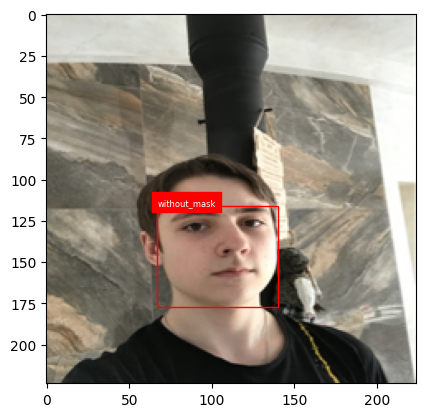

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def load_random_example(dataset):
    random_entry = random.choice(dataset)
    image_path = random_entry['image_path']
    annotations = random_entry['annotations']

    image = plt.imread(image_path)

    fig, ax = plt.subplots()
    ax.imshow(image)

    for ann in annotations:
        rect = patches.Rectangle(
            (ann['xmin'], ann['ymin']),
            ann['xmax'] - ann['xmin'],
            ann['ymax'] - ann['ymin'],
            linewidth=1,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            ann['xmin'],
            ann['ymin'] - 5,
            ann['label'],
            verticalalignment='top',
            color='white',
            fontsize=6,
            backgroundcolor='red'
        )

    plt.show()

# Assuming 'dataset' is defined in your local scope and contains the loaded dataset
load_random_example(dataset)

Supervised Learning

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Preprocess the data
def preprocess_data(dataset):
    images = []
    labels = []

    for entry in dataset:
        # Load the image from the path
        image = Image.open(entry['image_path']).convert('RGB')  # Convert image to RGB
        image = image.resize((IMG_WIDTH, IMG_HEIGHT))
        images.append(np.array(image))

        # Check if any 'with_mask' label exists in annotations
        label = 1 if any(box['label'] == 'with_mask' for box in entry['annotations']) else 0
        labels.append(label)

    images = np.array(images) / 255.0  # Normalize the images
    labels = to_categorical(labels)  # Convert labels to one-hot encoding

    return images, labels

images, labels = preprocess_data(dataset)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Design the CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 for with and without mask
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=1, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

6/6 [==============================] - 5s 674ms/step - loss: 0.3767 - accuracy: 0.9181
Test accuracy: 0.9181286692619324


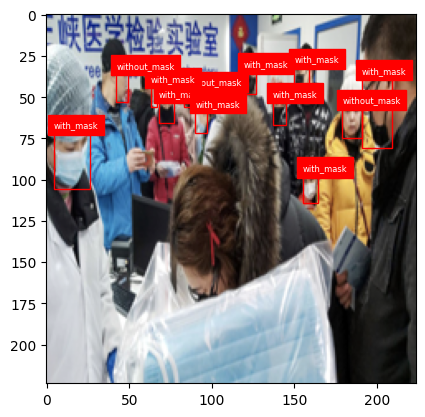

None


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def load_random_example(dataset):
    random_entry = random.choice(dataset)
    image_path = random_entry['image_path']
    annotations = random_entry['annotations']

    image = Image.open(image_path)

    fig, ax = plt.subplots()
    ax.imshow(image)

    for ann in annotations:
        rect = patches.Rectangle(
            (ann['xmin'], ann['ymin']),
            ann['xmax'] - ann['xmin'],
            ann['ymax'] - ann['ymin'],
            linewidth=1,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            ann['xmin'],
            ann['ymin'] - 5,
            ann['label'],
            verticalalignment='top',
            color='white',
            fontsize=6,
            backgroundcolor='red'
        )

    plt.show()

# Assuming 'dataset' is defined in your local scope and contains the loaded dataset
random_entry = load_random_example(dataset)
print(random_entry)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

# Print the metrics
print("\nSupervised Learning")
print(f"Accuracy:   {accuracy * 100:.2f}%")
print(f"Precision:  {precision * 100:.2f}%")
print(f"Recall:     {recall * 100:.2f}%")
print(f"F1-Score:   {f1 * 100:.2f}%")

6/6 [==============================] - 7s 1s/step

Supervised Learning
Accuracy:   91.81%
Precision:  45.91%
Recall:     50.00%
F1-Score:   47.87%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


VGG16 From Scratch

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from PIL import Image

# Assuming 'dataset' is already defined and preprocessed
def preprocess_data_vgg(dataset):
    images = []
    labels = []

    for entry in dataset:
        image = Image.open(entry['image_path']).convert('RGB')
        image = image.resize((224, 224))
        images.append(np.array(image))
        label = 1 if any(box['label'] == 'with_mask' for box in entry['annotations']) else 0
        labels.append(label)

    images = np.array(images)
    labels = to_categorical(labels)  # One-hot encode the labels
    return images, labels

images, labels = preprocess_data_vgg(dataset)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

def VGG16_scratch(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    # Add additional Conv layers here...
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=input, outputs=predictions)
    return model

model_scratch = VGG16_scratch((224, 224, 3))
model_scratch.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_scratch = model_scratch.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

y_pred_scratch = model_scratch.predict(X_test)
y_pred_scratch_classes = np.argmax(y_pred_scratch, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy_scratch = accuracy_score(y_test_classes, y_pred_scratch_classes)
precision_scratch = precision_score(y_test_classes, y_pred_scratch_classes, average='macro')
recall_scratch = recall_score(y_test_classes, y_pred_scratch_classes, average='macro')
f1_score_scratch = f1_score(y_test_classes, y_pred_scratch_classes, average='macro')

print(f'Accuracy from scratch: {accuracy_scratch * 100:.2f}%')
print(f'Precision from scratch: {precision_scratch:.2f}')
print(f'Recall from scratch: {recall_scratch:.2f}')
print(f'F1-Score from scratch: {f1_score_scratch:.2f}')


Epoch 1/10
22/22 [==============================] - 677s 31s/step - loss: 174.6192 - accuracy: 0.7830 - val_loss: 0.4662 - val_accuracy: 0.9181
Epoch 2/10
22/22 [==============================] - 631s 29s/step - loss: 0.3552 - accuracy: 0.8959 - val_loss: 0.2586 - val_accuracy: 0.9181
Epoch 3/10
22/22 [==============================] - 634s 29s/step - loss: 0.3012 - accuracy: 0.8974 - val_loss: 0.2536 - val_accuracy: 0.9240
Epoch 4/10
22/22 [==============================] - 635s 29s/step - loss: 0.2891 - accuracy: 0.8944 - val_loss: 0.2430 - val_accuracy: 0.9181
Epoch 5/10
22/22 [==============================] - 637s 29s/step - loss: 0.2519 - accuracy: 0.8988 - val_loss: 0.2490 - val_accuracy: 0.9181
Epoch 6/10
22/22 [==============================] - 632s 29s/step - loss: 0.2441 - accuracy: 0.9076 - val_loss: 0.3074 - val_accuracy: 0.9181
Epoch 7/10
22/22 [==============================] - 633s 29s/step - loss: 0.2373 - accuracy: 0.9091 - val_loss: 0.2608 - val_accuracy: 0.9064
Epoc

VGG16 with Transfer Learning

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from PIL import Image

# Assuming 'dataset' is already defined and preprocessed
images, labels = preprocess_data_vgg(dataset)  # Same preprocessing function as above

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
model_transfer = Model(inputs=base_model.input, outputs=predictions)

model_transfer.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_transfer = model_transfer.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

y_pred_transfer = model_transfer.predict(X_test)
y_pred_transfer_classes = np.argmax(y_pred_transfer, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy_transfer = accuracy_score(y_test_classes, y_pred_transfer_classes)
precision_transfer = precision_score(y_test_classes, y_pred_transfer_classes, average='macro')
recall_transfer = recall_score(y_test_classes, y_pred_transfer_classes, average='macro')
f1_score_transfer = f1_score(y_test_classes, y_pred_transfer_classes, average='macro')

print(f'Accuracy with transfer learning: {accuracy_transfer * 100:.2f}%')
print(f'Precision with transfer learning: {precision_transfer:.2f}')
print(f'Recall with transfer learning: {recall_transfer:.2f}')
print(f'F1-Score with transfer learning: {f1_score_transfer:.2f}')


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
22/22 [==============================] - 580s 27s/step - loss: 7.0531 - accuracy: 0.8666 - val_loss: 1.0188 - val_accuracy: 0.9415
Epoch 2/10
22/22 [==============================] - 563s 26s/step - loss: 0.7733 - accuracy: 0.9663 - val_loss: 0.4200 - val_accuracy: 0.9591
Epoch 3/10
22/22 [==============================] - 567s 26s/step - loss: 0.1643 - accuracy: 0.9883 - val_loss: 0.7845 - val_accuracy: 0.9649
Epoch 4/10
22/22 [==============================] - 523s 24s/step - loss: 0.0958 - accuracy: 0.9927 - val_loss: 0.9331 - val_accuracy: 0.9708
Epoch 5/10
22/22 [==============================] - 571s 26s/step - loss: 0.0031 - accuracy: 0.9985 - val_loss: 0.9018 - val_accuracy: 0.9708
Epoch 6/10
22/22 [==============================] - 561s 26s/step - loss: 5.1676e-05 - accuracy: 1.0000 - val_loss: 0.8983 - val_accuracy: 0.9708
Epoch 7/10
22/22 [==============================] - 559s 26s/step - loss: 0.053